In [71]:
%matplotlib inline
from deco.imports import *
import json
from pprint import pprint
import sklearn.ensemble as st
from datetime import datetime
import random

In [3]:
PATH = '/home/rotem/Documents/code/optimization-course/'

In [4]:
def extract_weather(weather_obj):
    correct_weather = [item for item in weather_obj['list']
                       if item['sys']['country'] == 'GB' or item['coord']['lat'] == 51.5085][0]
    weather_output = {
        'rain': correct_weather['rain'],
        'snow': correct_weather['snow'],
#         'wind_deg': correct_weather['wind'].get('deg', 0),
        'wind_speed': correct_weather['wind'].get('speed', 0),
        'feels_like': correct_weather['main'].get('feels_like', correct_weather['main']['temp']),
        'humidity': correct_weather['main']['humidity'],
        'pressure': correct_weather['main']['pressure'],
        'temp': correct_weather['main']['temp'],
        'temp_max': correct_weather['main']['temp_max'],
        'temp_min': correct_weather['main']['temp_min'],
        
    }
    weather_output['rain'] = list(weather_output['rain'].values())[0] if weather_output['rain'] is not None else 0
    weather_output['snow'] = list(weather_output['snow'].values())[0] if weather_output['snow'] is not None else 0
    for cloud_key, cloud_value in correct_weather['clouds'].items():
        weather_output['clouds_' + cloud_key] = cloud_value
    return weather_output

In [5]:
def prepare_row(row_json):
    row = json.loads(row_json)
    weather = row.pop('weather')
    weather = extract_weather(weather)
    row.update(weather)
    return row

In [6]:
def load_jsons_to_df(file_name):
    with open(file_name) as F:
        rows = F.readlines()
    data = []
    for row in rows:
        try:
            data.append(prepare_row(row))
        except Exception as e:
            pprint(e)
            pprint(row)
    return pd.DataFrame(data)

In [7]:
df = load_jsons_to_df(PATH + 'data.json')

In [8]:
def enrich_prev_temp(df):
    x = df[['timestamp', 'temp']].drop_duplicates()
    x.timestamp = x.timestamp.str.slice(0, 13)
    x = x.drop_duplicates().sort_values('timestamp').reset_index(drop=True)
    prev_temp = x.join(x[x.index > 0].reset_index(drop=True), lsuffix='_prev')
    prev_d = {}
    for row in prev_temp.values:
        prev_d[row[2]] = prev_d.get(row[2], {})
        prev_d[row[2]][row[3]] = row[1]
    df['prev_temp'] = df.apply(lambda r: prev_d.get(r['timestamp'][:13], {}).get(r['temp'], r['temp']), axis=1)
    return df

In [9]:
def enrich_rain_snow_daily_mean(df):
    x = df.copy()
    x['hour'] = x.timestamp.str.slice(11, 13)
    x.timestamp = x.timestamp.str.slice(0, 10)
    x = x[['timestamp', 'hour', 'rain', 'snow']]
    rain_mean = x.groupby(['timestamp', 'hour'], as_index=False).max().groupby(['timestamp'], as_index=False).mean().values
    rain_mean = {row[0]: (row[1], row[2]) for row in rain_mean}
    df['rain_mean'] = df.timestamp.apply(lambda timestamp: rain_mean[timestamp[:10]][0])
    df['snow_mean'] = df.timestamp.apply(lambda timestamp: rain_mean[timestamp[:10]][1])
    return df

In [10]:
def add_sample_diff(df):
    df.from_time = pd.to_datetime(df.from_time)
    df.timestamp = pd.to_datetime(df.timestamp)
    df['sample_diff'] = (df.timestamp - df.from_time).dt.total_seconds()
    return df

In [11]:
def add_date_parts(df):
    attrs = ['Dayofweek', 'Hour', 'Minute']
    for attr in attrs:
        df[f'from_time_{attr.lower()}'] = getattr(df.from_time.dt, attr.lower())
    return df

In [109]:
def prepare_df(df):
    df = df.copy()
    df = df[(df.duration >= 12) & (df.duration < 28)]
#     df.duration = df.duration.apply(lambda val: val + random.random() * 2 - 1)
#     df.duration = df.duration.apply(lambda val: val if val != 28 or random.random() > 0.8 else None)
#     df = df[df.duration.notnull()]
    features = [enrich_prev_temp, enrich_rain_snow_daily_mean, add_sample_diff, add_date_parts]
    for feature in features:
        df = feature(df)
#     df = df[df.sample_diff < 800]
    df = df[[column for column in df.columns if column not in ('origin', 'destination', 'to_time', 'timestamp', 'from_time')]]
    return df

In [110]:
res = prepare_df(df)
res

,duration,rain,snow,wind_speed,feels_like,humidity,pressure,temp,temp_max,temp_min,clouds_all,prev_temp,rain_mean,snow_mean,sample_diff,from_time_dayofweek,from_time_hour,from_time_minute
0,23,0.0,0.0,4.6,3.01,93,1020,7.13,8.33,6.0,22,7.13,0.0,0.0,828.0,0,21,23
1,23,0.0,0.0,4.6,3.01,93,1020,7.13,8.33,6.0,22,7.13,0.0,0.0,108.0,0,21,35
2,23,0.0,0.0,4.6,3.01,93,1020,7.13,8.33,6.0,22,7.13,0.0,0.0,-612.0,0,21,47
4,23,0.0,0.0,4.6,3.01,93,1020,7.13,8.33,6.0,22,7.13,0.0,0.0,770.0,0,21,29
5,23,0.0,0.0,4.6,3.01,93,1020,7.13,8.33,6.0,22,7.13,0.0,0.0,50.0,0,21,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15217,26,0.0,0.0,2.1,4.77,93,1032,7.14,8.00,6.0,75,6.89,0.0,0.0,16.0,3,13,3
15218,26,0.0,0.0,2.1,4.77,93,1032,7.14,8.00,6.0,75,6.89,0.0,0.0,-464.0,3,13,11
15220,27,0.0,0.0,2.1,4.77,93,1032,7.14,8.00,6.0,75,6.89,0.0,0.0,557.0,3,12,59
15221,26,0.0,0.0,2.1,4.77,93,1032,7.14,8.00,6.0,75,6.89,0.0,0.0,17.0,3,13,8


In [111]:
train_df = res.sample(frac=0.8)
test_df = res[~ res.index.isin(train_df.index.values)]
x_train, y_train = train_df.drop('duration', axis=1), train_df.duration
x_test, y_test = test_df.drop('duration', axis=1), test_df.duration

In [93]:
def l1_diff(x, y):
    return abs((x-y)).mean()

In [94]:
def print_score(m):
    res = [l1_diff(m.predict(x_train), y_train), l1_diff(m.predict(x_test), y_test),
                m.score(x_train, y_train), m.score(x_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [112]:
m = st.RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.9, min_samples_leaf=3 )
m.fit(x_train, y_train)
print_score(m)

[0.05514097773204332, 0.07679023257767081, 0.9927841889151547, 0.9924905212330026]


In [103]:
m = st.GradientBoostingRegressor

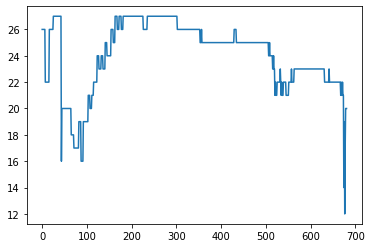

In [119]:
p = prepare_df(df[(df.from_time > '2020-01-10') & (df.from_time < '2020-01-11')]).sort_values(['from_time_hour', 'from_time_minute']).reset_index(drop=True)
# plt.plot(p.index, m.predict(p.drop('duration', axis=1)))
# plt.plot(dd.index, m.predict(dd))
plt.plot(p.index, p.duration)

In [114]:
d = (dict(
    zip(list(p.columns), list(p.values[0]))
       ))

In [22]:
d['feels_like']: 6.5
d['sample_diff'] = 0
items = []
for hour in range(24):
    for minute in range(60):
        dd = d.copy()
        dd['from_time_hour'] = hour
        dd['from_time_minute'] = minute
        items.append(dd)
dd = pd.DataFrame(items)

,rain,snow,wind_speed,feels_like,humidity,pressure,temp,temp_max,temp_min,clouds_all,prev_temp,rain_mean,snow_mean,sample_diff,from_time_dayofweek,from_time_hour,from_time_minute
0,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,0,0
1,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,0,1
2,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,0,2
3,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,0,3
4,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,23,55
1436,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,23,56
1437,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,23,57
1438,0.0,0.0,8.2,-0.82,76.0,1006.0,6.5,9.0,4.0,20.0,6.5,0.0,0.0,0,4.0,23,58


Result: 278.54558935106695
Should be: 278.546 km


/home/rotem/Documents/code/ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


279.35290160386563

In [135]:
d = pd.read_csv(PATH + 'nyc-weather.csv')
d[d.NAME == 'NY CITY CENTRAL PARK, NY US'][['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5']]

,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
19964,40.0,26.0,0.0,0.0,0.0,6.93,310.0,300.0,15.0,25.9
19965,33.0,22.0,0.0,0.0,0.0,5.82,310.0,340.0,15.0,21.9
19966,32.0,24.0,0.0,0.0,0.0,4.47,260.0,260.0,13.0,19.9
19967,37.0,30.0,0.0,0.0,0.0,8.05,290.0,250.0,17.9,28.0
19968,42.0,32.0,0.0,0.0,0.0,6.71,310.0,310.0,17.0,25.9
...,...,...,...,...,...,...,...,...,...,...
20325,55.0,36.0,0.0,0.0,0.0,7.16,250.0,240.0,16.1,27.1
20326,48.0,41.0,1.2,0.0,0.0,6.04,60.0,320.0,16.1,25.9
20327,45.0,23.0,0.0,0.0,0.0,6.26,300.0,300.0,15.0,25.1
20328,32.0,21.0,0.0,0.0,0.0,5.82,290.0,280.0,17.0,28.0
